In [1]:
#Importing the required libraries 
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

C:\Users\ADMIN\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
#Importing the required libraries for web scraping
import requests
from bs4 import BeautifulSoup
import bs4
from fastnumbers import isfloat 
from fastnumbers import fast_float
from multiprocessing.dummy import Pool as ThreadPool 

# Web Scraping

In [3]:
#Data cleaning functions for web scraping

def ffloat(string): #Cleans the commas and % from the string given
    if string is None:
        return np.nan
    if type(string)==float or type(string)==np.float64:
        return string
    if type(string)==int or type(string)==np.int64:
        return string
    return fast_float(string.split(" ")[0].replace(',','').replace('%',''),
                      default=np.nan)

def ffloat_list(string_list): #Cleans the string from a whole list of string
    return list(map(ffloat,string_list))

def remove_multiple_spaces(string): #Strips the spaces from string
    if type(string)==str:
        return ' '.join(string.split())
    return string

def get_children(html_content): #Gets the child content from the html tag, usually for tables where <td> is a child of <tr>
    return [item for item in html_content.children if 
            type(item)==bs4.element.Tag or 
            len(str(item).replace("\n","").strip())>0]

In [4]:
response = requests.get("https://finance.yahoo.com/gainers", timeout=240) #Establishes a connection to the website   
response.status_code #If its more than 240, then the connection is not established

200

In [5]:
html = BeautifulSoup(response.content, "html.parser") #Gets the html content of the page

In [6]:
def get_table_simple(table,is_table_tag=True): #Changes the table data in the form of a list
    elems = table.find_all('tr') if is_table_tag else get_children(table)
    table_data = list()
    for row in elems:
        row_data = list()
        row_elems = get_children(row)
        for elem in row_elems:
            text = elem.text.strip().replace("\n","")
            text = remove_multiple_spaces(text)
            if len(text)==0:
                continue
            row_data.append(text)
        table_data.append(row_data)
    return table_data

In [7]:
init_list = get_table_simple(html) #Gets the table from top gained and saves it as init_list
top5list = [] #Creates an empty list
for x in range(6): #Selects the top 5 of the table from top gained (0-5 as 0 is the headings and labels)
    top5list.append(init_list[x]) #appends it to the top5 list
dftop5gainers = pd.DataFrame.from_records(top5list) #Change the list into a dataframe
print("Top 5 gainers currently are: ")
dftop5gainers

Top 5 gainers currently are: 


,0,1,2,3,4,5,6,7,8,9
0,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
1,ZS,"Zscaler, Inc.",98.09,+22.29,+29.41%,22.809M,3.35M,12.688B,N/A,None
2,PTKFF,PT Kalbe Farma Tbk.,0.1020,+0.0220,+27.50%,5.158M,"381,555",5.58B,N/A,None
3,TBVPF,Thai Beverage Public Company Limited,0.5500,+0.1150,+26.44%,"25,909","102,600",14.231B,25.00,None
4,PTXKY,PT XL Axiata Tbk,3.8000,+0.7200,+23.38%,"47,587","8,388",2.266B,N/A,None
5,NWAU,"Consumer Automotive Finance, Inc.",0.0225,+0.0028,+14.21%,"549,897","523,927",39.381B,N/A,None


# Analysis

In [8]:
#Reads the data and changes it into a dataframe
df5183 = web.DataReader('5183.KL', data_source='yahoo', start='2011-03-12',end='2020-03-12')

In [9]:
#Creates a new column to show the difference between the open and close of the data (how much it rises or falls in a day)
df5183['Difference'] = df5183['Open'] - df5183['Close']
df5183.head()

,High,Low,Open,Close,Volume,Adj Close,Difference
Date,,,,,,,
2011-03-14,6.82,6.47,6.52,6.75,17068200.0,5.005249,-0.23
2011-03-15,6.77,6.56,6.75,6.59,17123100.0,4.886606,0.16
2011-03-16,6.67,6.58,6.62,6.63,13315400.0,4.916266,-0.01
2011-03-17,6.65,6.58,6.63,6.63,7634200.0,4.916266,0.00
2011-03-18,6.71,6.62,6.66,6.70,13221200.0,4.968173,-0.04


In [10]:
df5183.tail()

,High,Low,Open,Close,Volume,Adj Close,Difference
Date,,,,,,,
2020-03-06,5.67,5.52,5.64,5.65,3884700.0,5.566207,-0.01
2020-03-09,5.35,4.40,5.35,4.40,25781200.0,4.334746,0.95
2020-03-10,4.63,4.24,4.30,4.35,15704300.0,4.285487,-0.05
2020-03-11,4.79,4.38,4.45,4.72,13616300.0,4.650000,-0.27
2020-03-12,4.70,4.45,4.54,4.65,10009100.0,4.650000,-0.11


In [30]:
# Highest changes in stock price
print("Max increase in MYR: RM", round(df5183['Difference'].max(), 2))
print("Max decrease in MYR: RM",round(df5183['Difference'].min(), 2))

Max increase in MYR: RM 0.95
Max decrease in MYR: RM -0.46


In [31]:
# Max and min stock price
print("Max stock price: MYR", round(df5183['Adj Close'].max(), 2))
print("Min stock price: MYR", round(df5183['Adj Close'].min(), 2))

Max stock price: MYR 9.22
Min stock price: MYR 3.96


In [32]:
# Moving average of stock price
print("The moving average of stock price: ")
df5183['Adj Close'].sum() / len(df5183['Adj Close'])

The moving average of stock price: 


6.088083837273415

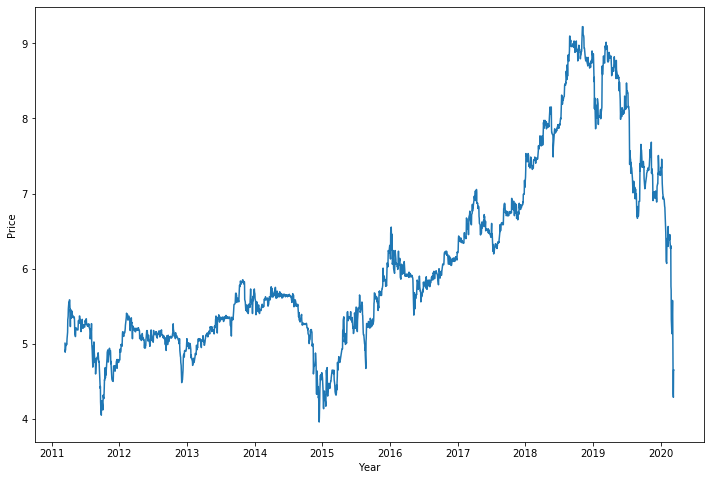

In [11]:
#Plots the figure based on adjusted close 
plt.figure(figsize = (12,8))
plt.plot(df5183['Adj Close'])
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

In [12]:
#Creates a csv for the dataframe
df5183.to_csv('pchem.csv')

# Training

In [13]:
#Creates a new list called dfPre, this is where we do the predictions
dfPre = []
dfPre = df5183[['Adj Close']]

In [14]:
print(dfPre.head())

            Adj Close
Date                 
2011-03-14   5.005249
2011-03-15   4.886606
2011-03-16   4.916266
2011-03-17   4.916266
2011-03-18   4.968173


In [15]:
#predict n days into the future, in this case, 30
forecast_out = 30 
#Creates a new column that is shifted based on the forecast_out
dfPre['Prediction'] = dfPre[['Adj Close']].shift(-forecast_out) 
print(dfPre.head())

            Adj Close  Prediction
Date                             
2011-03-14   5.005249    5.376008
2011-03-15   4.886606    5.361178
2011-03-16   4.916266    5.353763
2011-03-17   4.916266    5.346348
2011-03-18   4.968173    5.361178


C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
X = np.array(dfPre.drop(['Prediction'], 1))
len(X)  #Checks the amount of data

2225

In [17]:
#reserving 60 data for testing
X_new = X[0:2165] #Creates a new X ommitting 60 units of the data
len(X_new) + 60 #Check if the amount of data is correct 

2225

In [18]:
y = np.array(dfPre['Prediction']) #Creates a y with only the prediction column
y_new = y[:-60] #Takes away the last 60 columns 
len(y_new)

2165

In [19]:
#Split the data into train and test with a ratio of 1:5
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2) 

In [20]:
y = np.array(dfPre['Prediction'])
y = y[:-forecast_out] #Takes away the last n columns which were supposed to be predicted
print(y)
len(y)

[5.37600803 5.36117792 5.35376263 ... 4.28548717 4.64999962 4.6500001 ]


2195

In [21]:
lr = LinearRegression() #Creates the model
lr.fit(X_train, y_train) #Trains the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Testing

In [22]:
y_pre = lr.predict(X[2195:2225]) #Creates a list that stores the predictions of the last 30 days
print("Predicted last 30 days")
print(y_pre)

Predicted last 30 days
[6.11799102 6.08960363 6.35455092 6.3450883  6.41132524 6.36401307
 6.30723875 6.56272342 6.43025001 6.41132524 6.41132524 6.4586374
 6.39240046 6.44917478 6.4586374  6.36401307 6.27885182 6.31670137
 5.79626988 5.74895817 5.37046271 5.19067713 5.27583884 5.46508657
 5.6164843  5.60702214 4.42422404 4.37691188 4.72701996 4.72702041]


In [23]:
confidence = lr.score(X_test, y_test) #Checks the confidence score
print("Confidence Score: ", confidence)

Confidence Score:  0.9285776808618049


In [24]:
x_forecast = np.array(dfPre.drop(['Prediction'], 1))[-forecast_out:] #Checks the actual last 30 days
print("Actual last 30 days: ")
print(x_forecast)

Actual last 30 days: 
[[6.09819889]
 [6.06864357]
 [6.34449148]
 [6.33463955]
 [6.40360165]
 [6.35434294]
 [6.29523277]
 [6.56122875]
 [6.42330503]
 [6.40360165]
 [6.40360165]
 [6.45286036]
 [6.38389826]
 [6.44300842]
 [6.45286036]
 [6.35434294]
 [6.26567793]
 [6.30508471]
 [5.76324129]
 [5.71398306]
 [5.31991529]
 [5.13273287]
 [5.22139835]
 [5.41843224]
 [5.57605886]
 [5.56620741]
 [4.33474588]
 [4.28548717]
 [4.64999962]
 [4.6500001 ]]


Text(0, 0.5, 'Price')

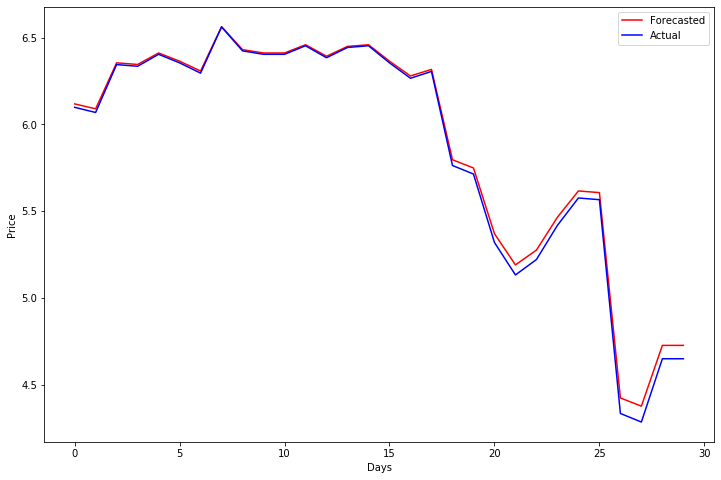

In [25]:
#Creates a graph that compares the actual with predicted results
plt.figure(figsize = (12,8))
plt.plot(y_pre, color='r')
plt.plot(x_forecast, color='b')
plt.legend(['Forecasted', 'Actual'])
plt.xlabel("Days")
plt.ylabel("Price")

In [26]:
print("Mean Squared Error: ", metrics.mean_squared_error(y_pre, x_forecast)) #Checks the mse

Mean Squared Error:  0.0015661276957722378


# Prediction

In [27]:
y_pre2 = [] 
y_pre2.append(np.array(y_pre)) #Creates 12 months worth of predicted data to predict a year into the future
for x in range(11): 
    y_pre_alt = y_pre2[x]
    y_pre_in = lr.predict(y_pre_alt.reshape(-1, 1))
    y_pre2.append(np.array(y_pre_in))

In [28]:
forward = []
for x in y_pre2: #Takes the 12 months of data and changes them from a 2-D list to a 1-D list
    for y in x:
        forward.append(y)

Text(0, 0.5, 'Price')

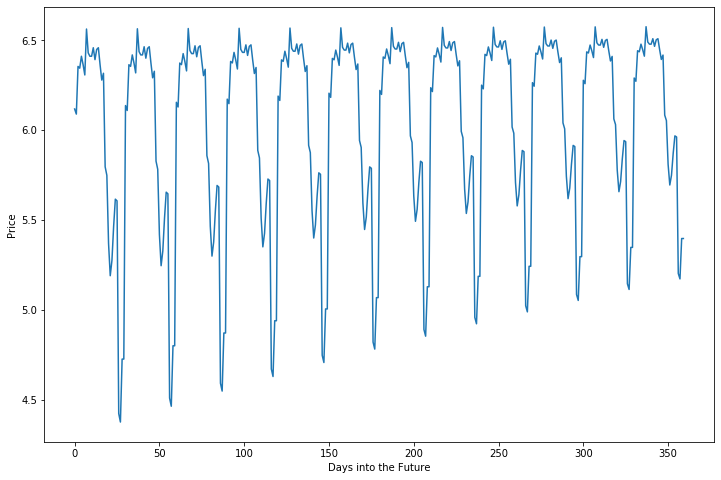

In [29]:
#The stock prices predicted from 1 day into the future, to a year into the future
plt.figure(figsize = (12,8))
plt.plot(forward)
plt.xlabel("Days into the Future")
plt.ylabel("Price")